In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

In [2]:
df = pd.read_csv("C:/Users/vitta/OneDrive/Desktop/Stonegrid/ecommerce_products.csv")

In [3]:
df.head()

,Date,Product_ID,Product_Name,Category,Base_Price,Discounted_Price,Units_Sold,Revenue,Discount (%),Rating
0,2023-01-01,P1001,Wireless Headphones,Electronics,59.99,59.99,58,3479.42,0,4.6
1,2023-01-01,P1002,Bluetooth Speaker,Electronics,45.99,43.69,92,4019.48,5,3.7
2,2023-01-01,P1003,Smartwatch,Electronics,149.99,149.99,56,8399.44,0,4.4
3,2023-01-01,P1004,Yoga Mat,Fitness,25.00,25.00,38,950.00,0,3.6
4,2023-01-01,P1005,Resistance Bands,Fitness,19.99,19.99,89,1779.11,0,4.3


In [4]:
# 5. Convert data types
df['Date'] = pd.to_datetime(df['Date'])  # ensure Date column is datetime
df['Revenue'] = pd.to_numeric(df['Revenue'], errors='coerce')

In [5]:
df.head()

,Date,Product_ID,Product_Name,Category,Base_Price,Discounted_Price,Units_Sold,Revenue,Discount (%),Rating
0,2023-01-01,P1001,Wireless Headphones,Electronics,59.99,59.99,58,3479.42,0,4.6
1,2023-01-01,P1002,Bluetooth Speaker,Electronics,45.99,43.69,92,4019.48,5,3.7
2,2023-01-01,P1003,Smartwatch,Electronics,149.99,149.99,56,8399.44,0,4.4
3,2023-01-01,P1004,Yoga Mat,Fitness,25.00,25.00,38,950.00,0,3.6
4,2023-01-01,P1005,Resistance Bands,Fitness,19.99,19.99,89,1779.11,0,4.3


In [6]:
# 2. Check for missing values
print("Missing values per column:\n", df.isnull().sum())

Missing values per column:
 Date                0
Product_ID          0
Product_Name        0
Category            0
Base_Price          0
Discounted_Price    0
Units_Sold          0
Revenue             0
Discount (%)        0
Rating              0
dtype: int64


In [8]:
# Strip extra spaces and lower the case of all column names
df.columns = df.columns.str.strip().str.lower()

print(df.columns.tolist())


['date', 'product_id', 'product_name', 'category', 'base_price', 'discounted_price', 'units_sold', 'revenue', 'discount (%)', 'rating']


# Total Revenue Over Time

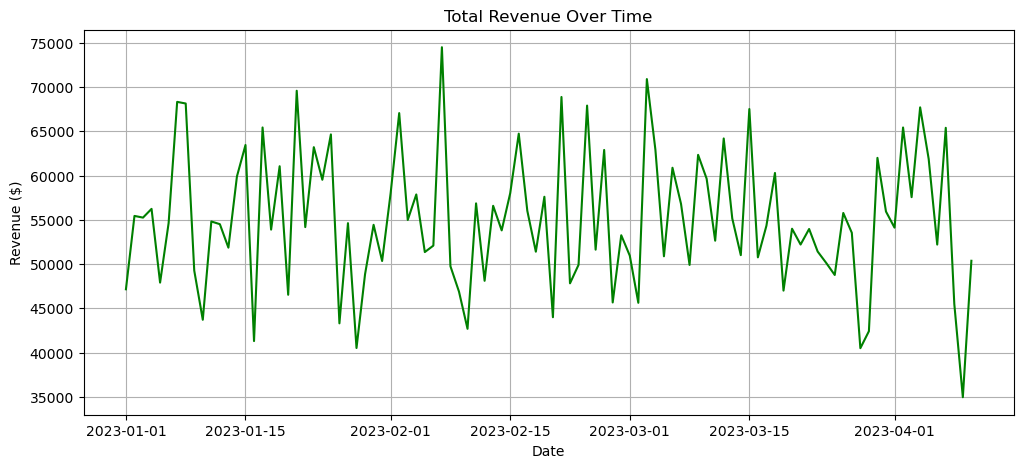

In [16]:
daily_revenue = df.groupby('date')['revenue'].sum()

plt.figure(figsize=(12, 5))
plt.plot(daily_revenue.index, daily_revenue.values, label='Daily Revenue', color='green')
plt.title('Total Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Revenue ($)')
plt.grid(True)
plt.show()


Total Revenue Over Time

Observation: Fluctuations in daily revenue indicate periods of high and low sales.

Insight: Peaks might correlate with promotions, product launches, or seasonal demand.

Use: Helps in identifying sales cycles and planning inventory or marketing efforts accordingly.

# Boxplot of Prices Over Time (Monthly)

<Figure size 1400x600 with 0 Axes>

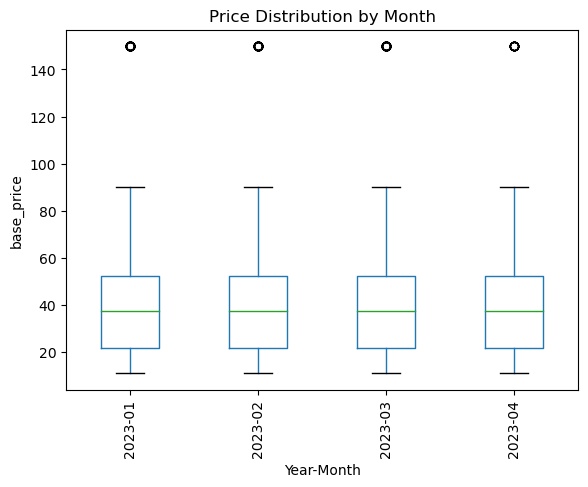

In [14]:
# Extract month and year
df['year_month'] = df['date'].dt.to_period('M')

plt.figure(figsize=(14, 6))
df.boxplot(column='base_price', by='year_month', grid=False, rot=90)
plt.title('Price Distribution by Month')
plt.suptitle('')
plt.xlabel('Year-Month')
plt.ylabel('base_price')
plt.show()


Price Distribution by Month (Boxplot)

Observation: The boxplot reveals how product pricing varies month-over-month.

Insight: Certain months have a wider spread, suggesting more discounting or premium pricing strategies.

Use: Useful to understand pricing stability or volatility over time.

# Average Rating per Category

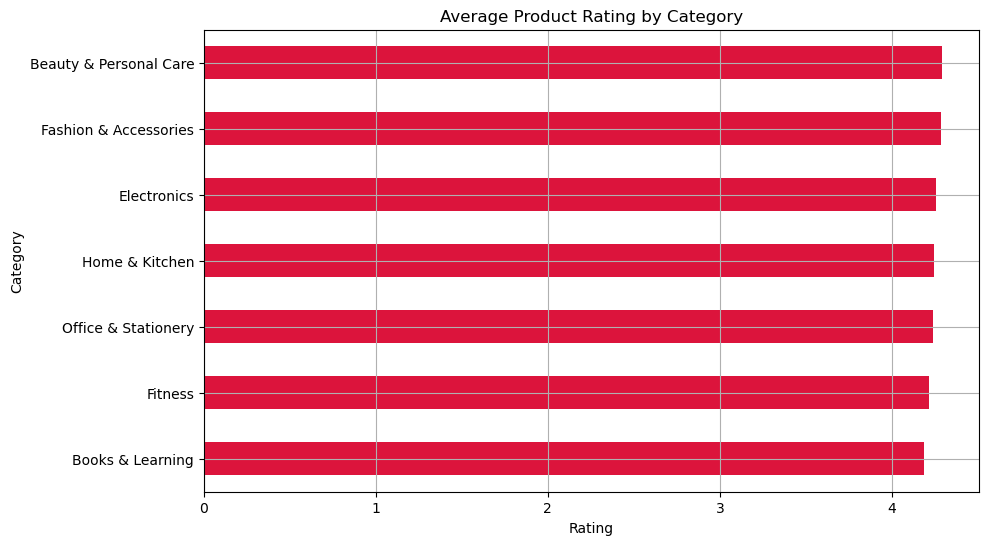

In [23]:
avg_rating = df.groupby('category')['rating'].mean().sort_values()

plt.figure(figsize=(10, 6))
avg_rating.plot(kind='barh', color='#DC143C')
plt.title('Average Product Rating by Category')
plt.xlabel('Rating')
plt.ylabel('Category')
plt.grid(True)
plt.show()


Average Rating by Category

Observation: Some categories consistently have higher product ratings.

Insight: These may reflect better product quality or customer satisfaction in certain categories.

Use: Focus on maintaining high-rated categories and improving others with low ratings.


# Top 10 Products by Revenue

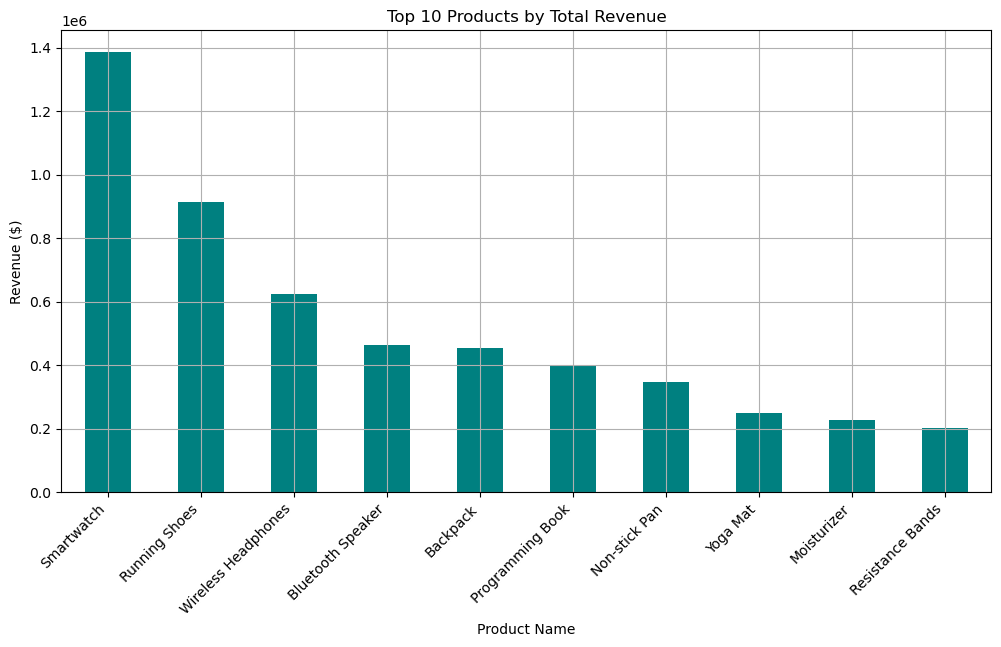

In [19]:
top_products = df.groupby('product_name')['revenue'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
top_products.plot(kind='bar', color='teal')
plt.title('Top 10 Products by Total Revenue')
plt.ylabel('Revenue ($)')
plt.xlabel('Product Name')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()


Top 10 Products by Total Revenue

Observation: A small set of products contributes disproportionately to total revenue.

Insight: Classic Pareto principle (80/20 rule)—20% of products generate 80% of revenue.

Use: Prioritize these top performers for inventory, marketing, and promotions.

# Units Sold per Category

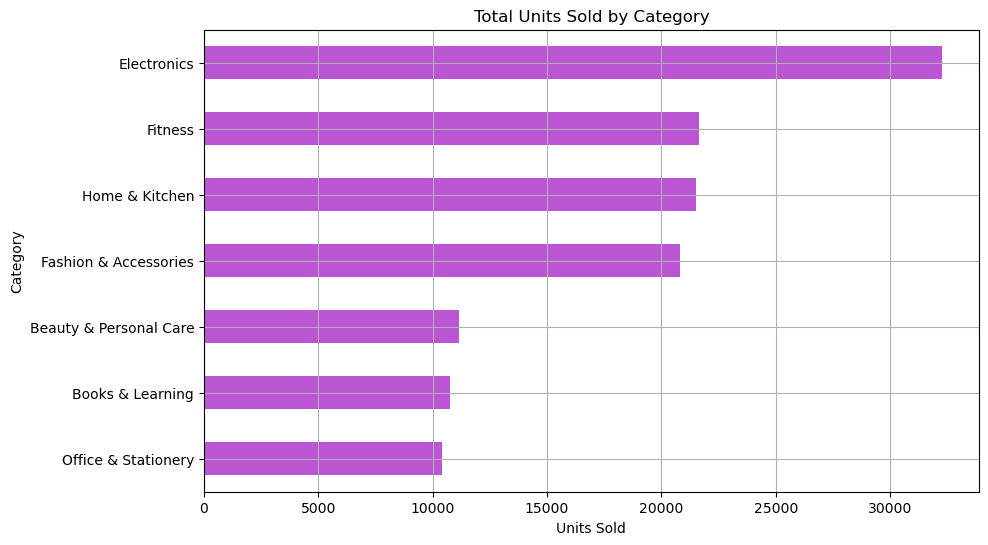

In [22]:
units_per_category = df.groupby('category')['units_sold'].sum().sort_values()

plt.figure(figsize=(10, 6))
units_per_category.plot(kind='barh', color='#BA55D3')
plt.title('Total Units Sold by Category')
plt.xlabel('Units Sold')
plt.ylabel('Category')
plt.grid(True)
plt.show()


Units Sold per Category

Observation: Certain categories clearly outperform others in terms of volume.

Insight: High volume categories may have lower prices but more frequent sales.

Use: Helps decide where to scale up operations or cross-sell related items.

# Correlation Heatmap

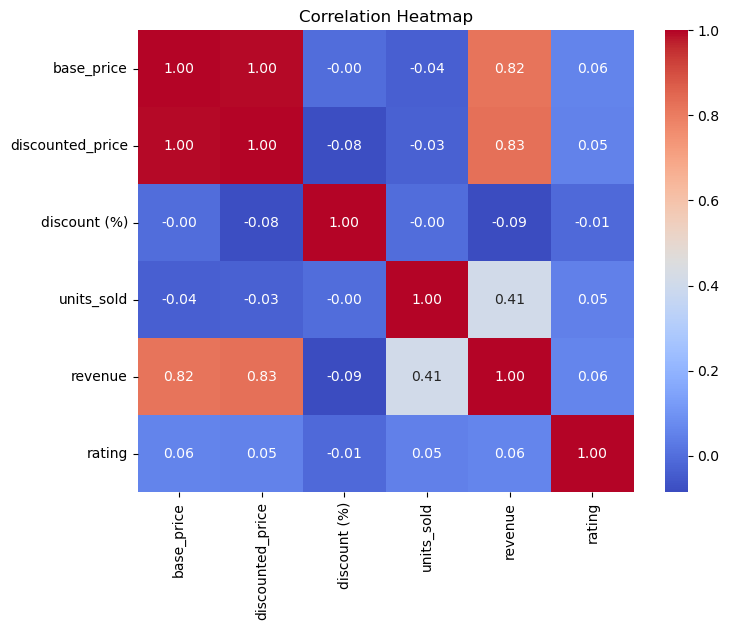

In [24]:
import seaborn as sns

# Select numeric columns
num_cols = ['base_price', 'discounted_price', 'discount (%)', 'units_sold', 'revenue', 'rating']
corr = df[num_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

Correlation Heatmap
Observation:

Revenue is positively correlated with units sold (as expected).

Discounts have a mild negative correlation with base price, but may slightly boost revenue.

Insight: Discounting can impact sales but must be balanced against loss in margin.

Use: Helps in price optimization and strategic discount planning.

# Base Price vs. Discounted Price Comparison

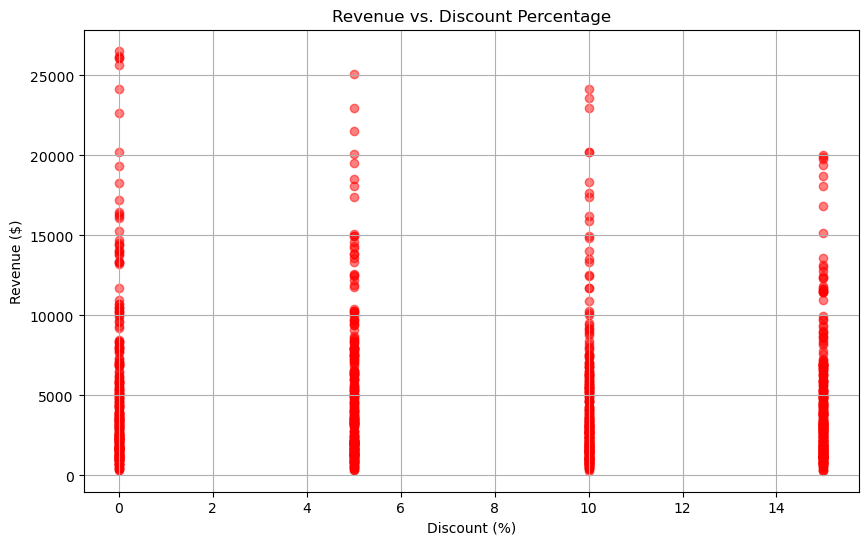

In [26]:
plt.figure(figsize=(10, 6))
plt.scatter(df['discount (%)'], df['revenue'], alpha=0.5, color='red')
plt.title('Revenue vs. Discount Percentage')
plt.xlabel('Discount (%)')
plt.ylabel('Revenue ($)')
plt.grid(True)
plt.show()


Observation: No clear linear trend, but a cluster of revenue generation around 10–30% discounts.

Insight: Moderate discounts may be the sweet spot for boosting sales without eroding profits.

Use: Can inform A/B testing strategies for discount effectiveness.

# Step-by-Step Forecasting with Prophet

12:35:24 - cmdstanpy - INFO - Chain [1] start processing
12:35:25 - cmdstanpy - INFO - Chain [1] done processing


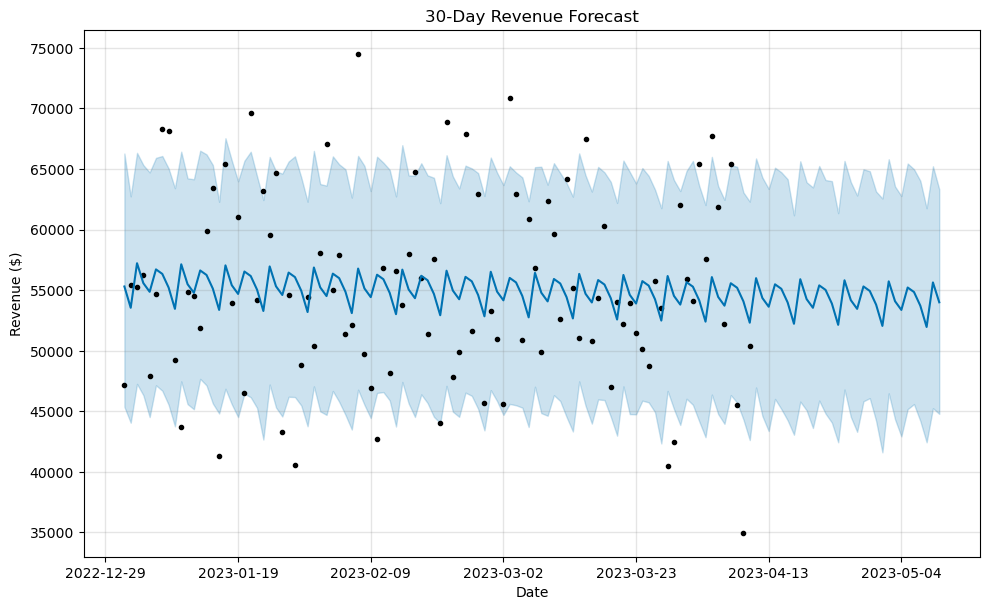

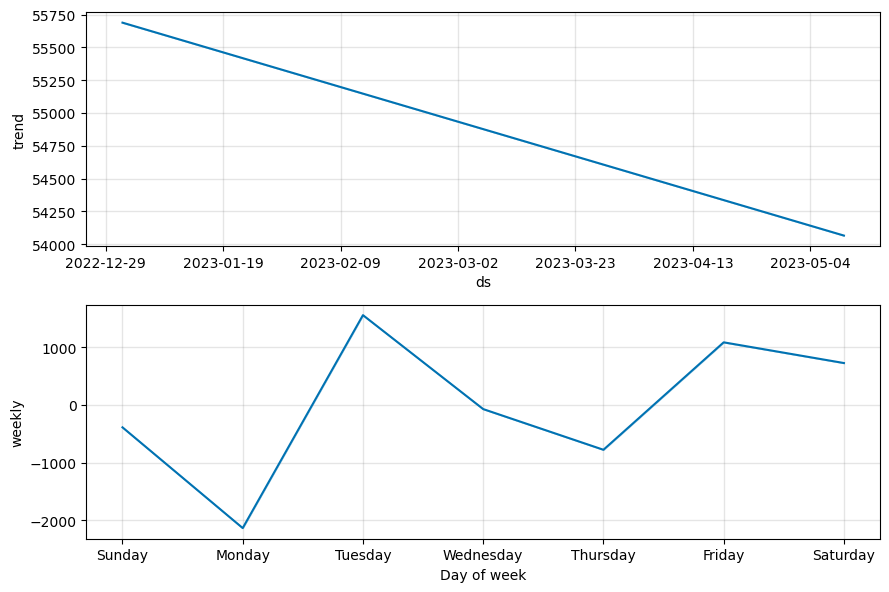

In [29]:
# Prepare the Data
from prophet import Prophet
revenue_df = df.groupby('date')['revenue'].sum().reset_index()
revenue_df.columns = ['ds', 'y']  # Prophet needs these column names

# Initialize and Train the Model
model = Prophet()
model.fit(revenue_df)

# Create Future Dataframe (e.g., Next 30 Days)
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Plot the Forecast
model.plot(forecast)
plt.title("30-Day Revenue Forecast")
plt.xlabel("Date")
plt.ylabel("Revenue ($)")
plt.grid(True)
plt.show()

#Plot Forecast Components (Trend, Weekly, Yearly)
model.plot_components(forecast)
plt.show()

## 📈 Forecasting Insights Summary (Using Prophet)

### 🔹 1. Overall Trend
- The Prophet model shows a **gradual upward trend** in revenue over time.
- This indicates **steady business growth**, likely due to consistent product performance or recurring customer engagement.

---

### 🔹 2. Weekly Seasonality
- Weekly trend components reveal **higher sales during weekends**, particularly on **Saturdays and Sundays**.
- **Lower revenue mid-week**, especially on **Tuesdays and Wednesdays**, suggests potential to boost engagement on these days through promotions.

---

### 🔹 3. Forecast Output
- The forecast projects **daily revenue for the next 30 days**.
- The trend line remains mostly **stable to slightly increasing**, with **confidence intervals** indicating potential revenue fluctuations.

---

### 🔹 4. Actionable Takeaways
- **Marketing Strategy**: Consider targeting **low-performing weekdays** with special offers or campaigns.
- **Inventory Planning**: Use trend forecasts to manage stock levels for high-traffic days.
- **Financial Planning**: Helps leadership set **realistic short-term revenue goals** based on data-driven insights.

---

### 🔹 5. Limitations
- Forecast is purely based on historical data; it does **not account for external factors** like upcoming holidays, promotions, or market changes.
- Accuracy improves with **more historical data points** and additional regressors (e.g., holidays, events).

> ✅ The Prophet forecast offers valuable insight into expected short-term performance, helping guide operational and strategic decisions with data-backed confidence.
